In [1]:
import os
import sys
import numpy as np

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

sys.stdout = open(os.devnull, "w") ## Prevents from printing

### File used to compute images:
#### full_body_phantom_paper_true_reco_jitter_thr0_25pes_phr.1_combined_all.h5 

In [2]:
def image_filename(path, shape, true_or_reco, tof):
    x, y, z  = shape
    return f'{path}/{true_or_reco}/{x}_{y}_{z}_{true_or_reco}_tof_{tof}_'#{it:02}.raw'

def read_images(path, shape, true_or_reco, tof, n_iter):
    rec = mr.MLEMReconstructor(libpath=path_to_mlem)
    rec.prefix = image_filename(path, shape, true_or_reco, tof)
    return np.array([rec.read_image(i) for i in range(0, n_iter)])

path_to_mlem     = '/Users/carmenromoluque/tofpet3d/lib/libmlem.so'
reco_prefix_base = '/Users/carmenromoluque/nexus_petit_analysis/full-body-phantom-paper/images_reco/jitter/rust_images/photo_range1mm/'
kinds  = (('true', 'OFF'),
          ('true',   200),
          ('true',   100), 
          ('true',    20),
          ('reco', 'OFF'),
          ('reco',   200),
          ('reco',   100), 
          ('reco',    20))
shape  = (60, 60, 60)
tot_it = 30
size   = (180, 180, 180)

from collections import namedtuple

kind_tof   = namedtuple('kind', 'true_or_reco tof')
the_images = {kind_tof(true_or_reco=true_or_reco, tof=tof): read_images(reco_prefix_base, shape, true_or_reco, tof, tot_it) 
              for true_or_reco, tof in kinds}


In [3]:
the_images;

In [4]:
def imshow_slice_integrated_along_z(ax, true_or_reco, tof, it, z_slice):
    image_slice = the_images[kind_tof(true_or_reco=true_or_reco, tof=tof)][it,:,:,z_slice]
    im_integrated_along_z = np.sum(image_slice, axis=2).transpose()
    fig0 = ax.imshow(im_integrated_along_z, origin='lower')
    title = f'{true_or_reco}, TOF = {tof}'
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('X (mm)', fontsize=13)
    ax.set_ylabel('Y (mm)', fontsize=13)
    #fig.colorbar(fig0, ax=ax, label='Events')

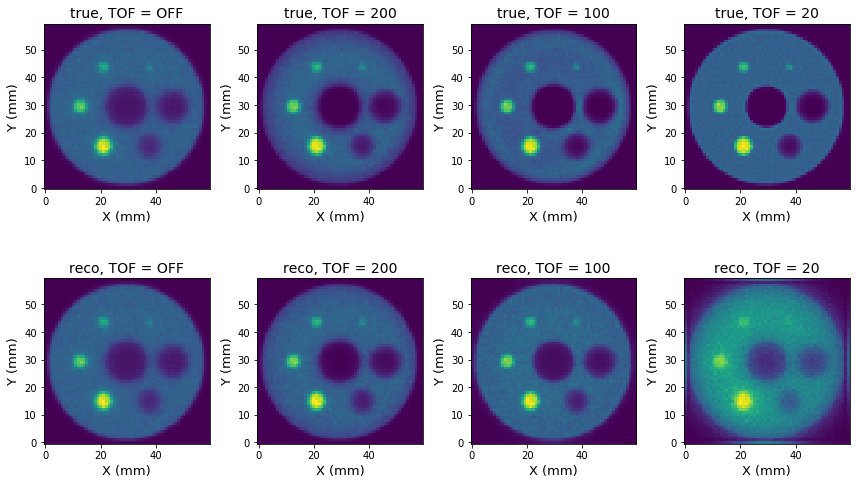

In [5]:
it       = 16
z_slice  = slice(25,35)
fig, axs = plt.subplots(2,4, figsize=(12, 8))
for ax, (true_or_reco, tof) in zip(axs.flatten(), kinds):
    imshow_slice_integrated_along_z(ax, true_or_reco, tof, it, z_slice)
    plt.tight_layout()
plt.show()

## Image parameters

In [6]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

In [7]:
num_hot     = 4
num_cold    = 2
num_spheres = num_hot + num_cold

sph_true_reco_tof = namedtuple('sph_true_reco_tof', 'sph, true_or_reco, tof')
snr_err           = namedtuple('snr_err'          , 'snrs, errs')

def get_snrs(images, kind_tof, n_sph):
    calculate_snrs_and_errs = lambda images: fomf.snr3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                        bckg_radius, phi0, phi_step, n_phi, 
                                                        x_size, y_size, z_size,
                                                        x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_snrs_and_errs, images[kind_tof]))
    snrs = [r[0] for r in all_images]
    errs = [e[1] for e in all_images]
    print(kind_tof, n_sph)
    return snr_err(snrs=snrs, errs=errs)

snrs = {sph_true_reco_tof(sph=n_sph, true_or_reco=true_or_reco, tof=tof) :
        get_snrs(the_images, kind_tof(true_or_reco=true_or_reco, tof=tof), n_sph)
        for true_or_reco, tof in kinds
        for n_sph in range(num_spheres)}

In [8]:
from typing import Sequence
from typing import Dict

def plot_snr_sphs(snrs:         Dict[sph_true_reco_tof, snr_err], 
                  spheres:      Sequence[int], 
                  true_or_reco: str,
                  tof:          int,
                  num_it:       int):
                  #colors:       Dict[sph_true_reco_tof, 'Color'], 
                  #lab:     str):
    for n_sphere in spheres:
        sphere = snrs  [sph_true_reco_tof(sph=n_sphere, true_or_reco=true_or_reco, tof=tof)]
        #color  = colors[sph_thresh_tof_nc(sph=n_sphere, th=th, tof=tof, nc=nc)]
        plt.errorbar(x = list(range(0, num_it)), 
                     y =    sphere.snrs[:num_it], 
                     yerr = sphere.errs[:num_it], 
                     xerr = None,
                     #color = color, 
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, ({true_or_reco, tof} rad)')

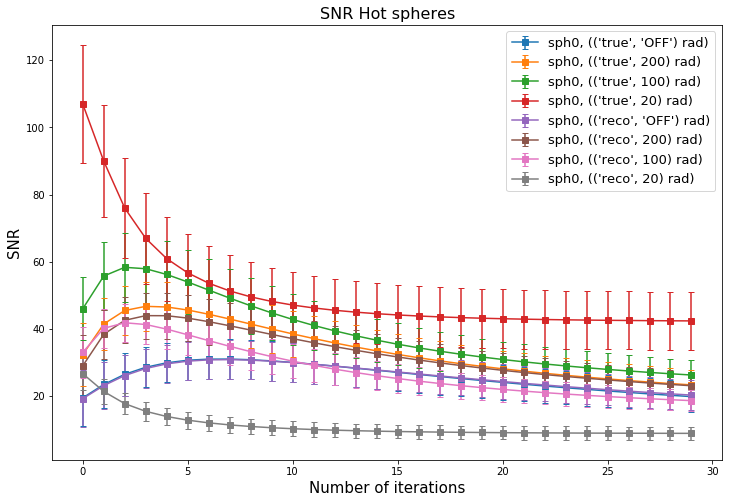

In [9]:
plt.figure(figsize=(12,8))
for true_or_reco, tof in kinds[:]:
    plot_snr_sphs(snrs, range(1), true_or_reco, tof=tof, num_it=30)
plt.title(f'SNR Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=1, fontsize=13, ncol=1);

In [10]:
def plot_snr_sphs_ax(snrs:         Dict[sph_true_reco_tof, snr_err], 
                     spheres:      Sequence[int], 
                     true_or_reco: str,
                     tof:          int,
                     num_it:       int,
                     ax):
                     #colors:       Dict[sph_true_reco_tof, 'Color'], 
                     #lab:     str):
    for n_sphere in spheres:
        sphere = snrs  [sph_true_reco_tof(sph=n_sphere, true_or_reco=true_or_reco, tof=tof)]
        #color  = colors[sph_thresh_tof_nc(sph=n_sphere, th=th, tof=tof, nc=nc)]
        ax.errorbar(x = list(range(0, num_it)), 
                     y =    sphere.snrs[:num_it], 
                     yerr = sphere.errs[:num_it], 
                     xerr = None,
                     #color = color, 
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, {true_or_reco}, TOF={tof}')

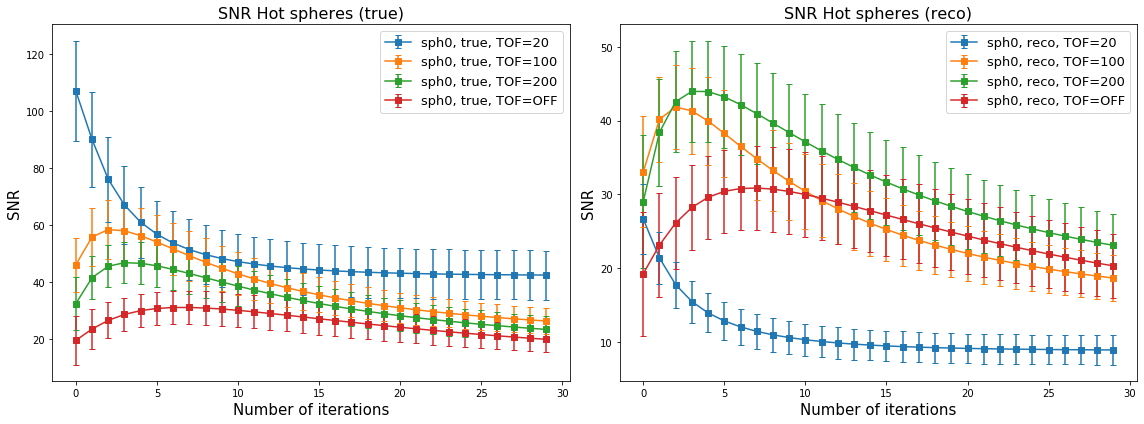

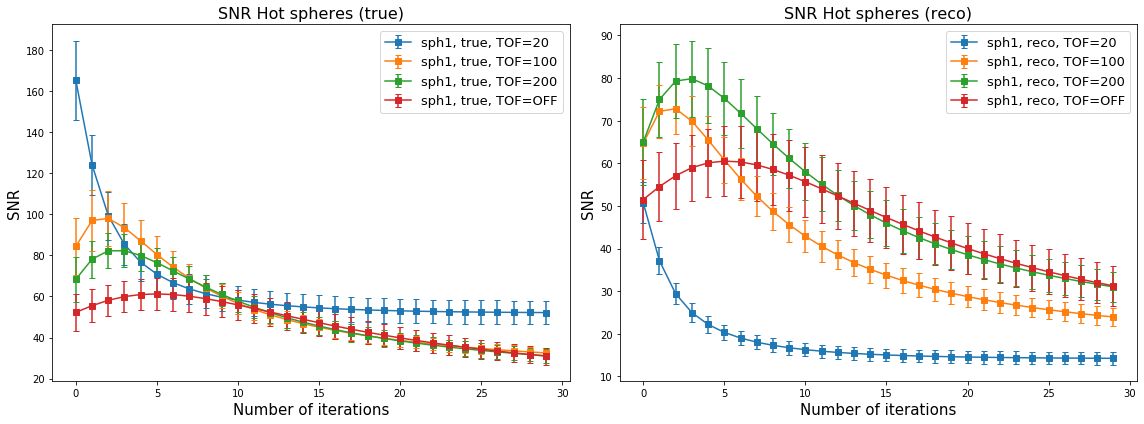

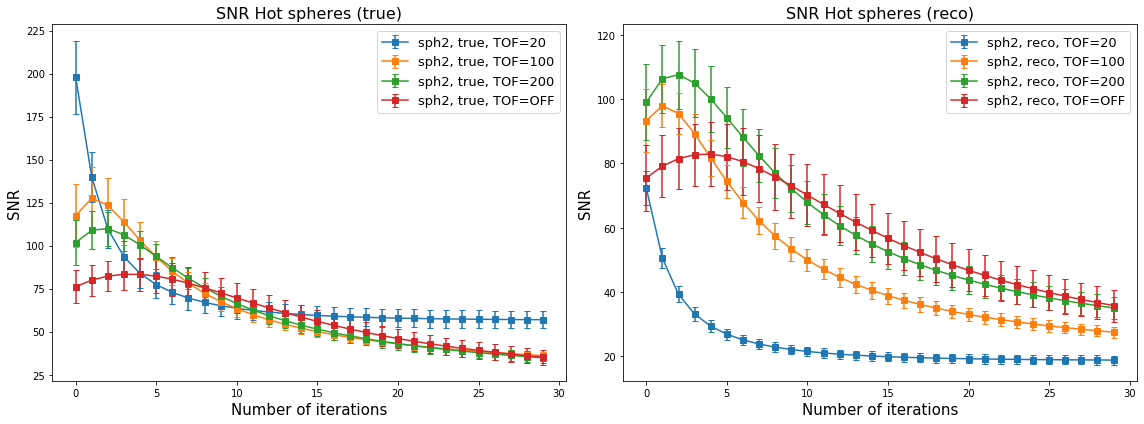

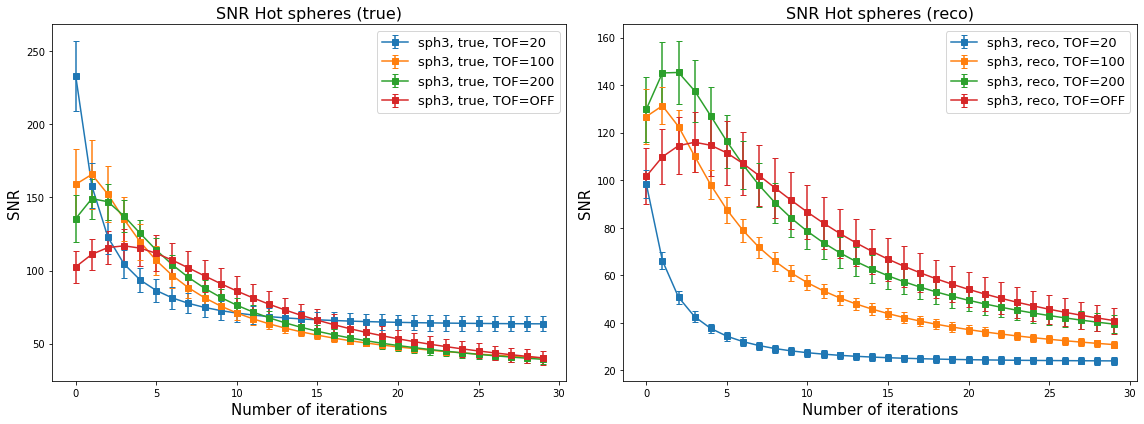

In [11]:
kd   = ['true', 'reco']
tofs = [20, 100, 200, 'OFF']
for sph in range(4):
    fig, axs = plt.subplots(1,2, figsize=(16, 6))
    for ax, true_or_reco in zip(axs.flatten(), kd):
        for tof in tofs:
            plot_snr_sphs_ax(snrs, range(sph, sph+1), true_or_reco, tof=tof, num_it=30, ax=ax)
        ax.set_title(f'SNR Hot spheres ({true_or_reco})', fontsize=16)
        ax.set_xlabel('Number of iterations', fontsize=15)
        ax.set_ylabel('SNR', fontsize=15)
        #ax.set_ylim(0, 200)
        ax.legend(loc=1, fontsize=13, ncol=1)
    plt.tight_layout()
    plt.show()

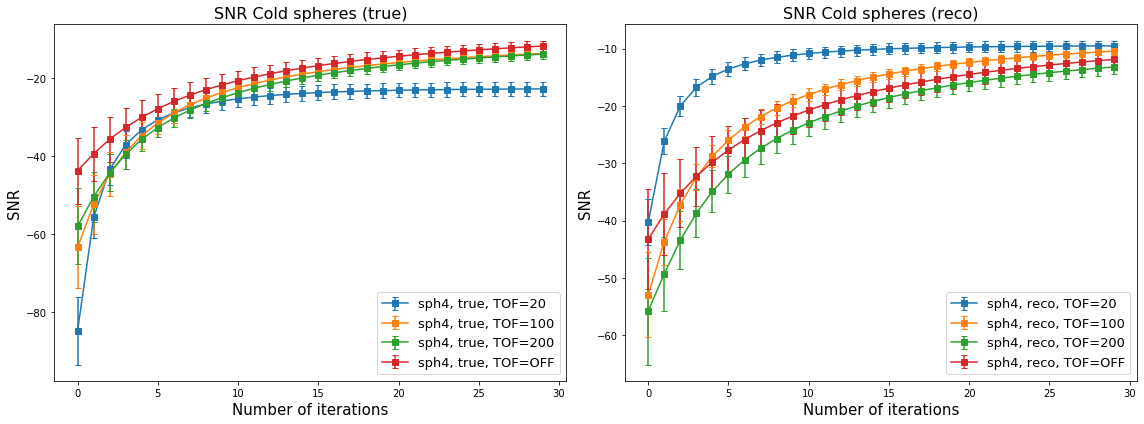

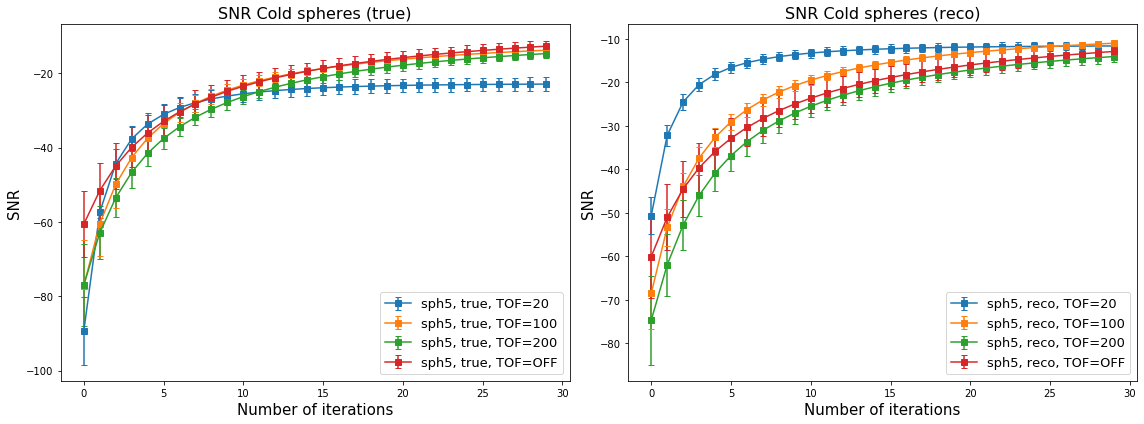

In [12]:
for sph in range(4,6):
    fig, axs = plt.subplots(1,2, figsize=(16, 6))
    for ax, true_or_reco in zip(axs.flatten(), kd):
        for tof in tofs:
            plot_snr_sphs_ax(snrs, range(sph, sph+1), true_or_reco, tof=tof, num_it=30, ax=ax)
        ax.set_title(f'SNR Cold spheres ({true_or_reco})', fontsize=16)
        ax.set_xlabel('Number of iterations', fontsize=15)
        ax.set_ylabel('SNR', fontsize=15)
        #ax.set_ylim(0, 200)
        ax.legend(loc=4, fontsize=13, ncol=1)
    plt.tight_layout()
    plt.show()

## CRC

In [13]:
crc_err = namedtuple('crc_err', 'crcs, errs')
sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, kind_tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[kind_tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(kind_tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_true_reco_tof(sph=n_sph, true_or_reco=true_or_reco, tof=tof):
        get_crcs(the_images, kind_tof(true_or_reco=true_or_reco, tof=tof), n_sph)
        for true_or_reco, tof in kinds
        for n_sph in range(4)}

In [14]:
def get_crcs_cold(images, kind_tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[kind_tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(kind_tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_true_reco_tof(sph=n_sph, true_or_reco=true_or_reco, tof=tof):
             get_crcs_cold(the_images, kind_tof(true_or_reco=true_or_reco, tof=tof), n_sph)
             for true_or_reco, tof in kinds
             for n_sph in range(4, 6)}

In [15]:
def plot_crc_sphs(crcs:         Dict[sph_true_reco_tof, crc_err], 
                  spheres:      Sequence[int], 
                  true_or_reco: str,
                  tof:          int,
                  num_it:       int):
    for n_sphere in spheres:
        sphere = crcs[sph_true_reco_tof(sph=n_sphere, true_or_reco=true_or_reco, tof=tof)]
            
        plt.errorbar(x = list(range(0, num_it)),
                     y =    sphere.crcs[:num_it], 
                     yerr = sphere.errs[:num_it], 
                     xerr = None,
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, ({true_or_reco, tof} rad)')

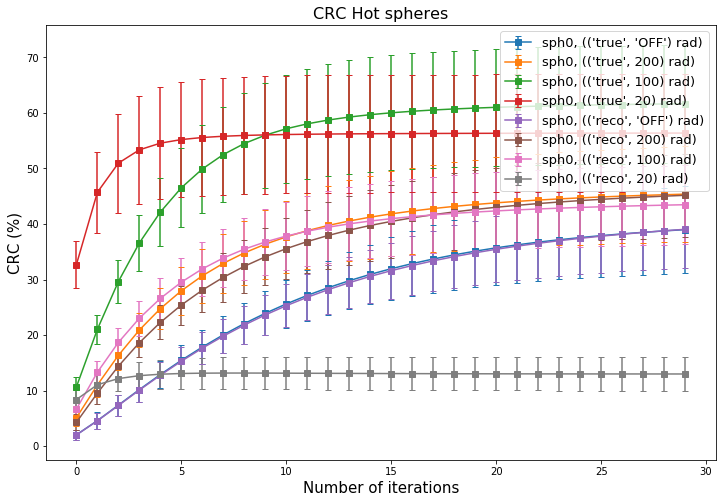

In [20]:
plt.figure(figsize=(12,8))
for true_or_reco, tof in kinds[:]:
    plot_crc_sphs(crcs, range(1), true_or_reco, tof=tof, num_it=30)
plt.title(f'CRC Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('CRC (%)', fontsize=15)
plt.legend(loc=1, fontsize=13, ncol=1);

In [17]:
def plot_crc_sphs_ax(crcs:         Dict[sph_true_reco_tof, crc_err], 
                     spheres:      Sequence[int], 
                     true_or_reco: str,
                     tof:          int,
                     num_it:       int,
                     ax):
    for n_sphere in spheres:
        sphere = crcs[sph_true_reco_tof(sph=n_sphere, true_or_reco=true_or_reco, tof=tof)]
        ax.errorbar(x = list(range(0, num_it)), 
                     y =    sphere.crcs[:num_it], 
                     yerr = sphere.errs[:num_it], 
                     xerr = None,
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, {true_or_reco}, TOF={tof}')

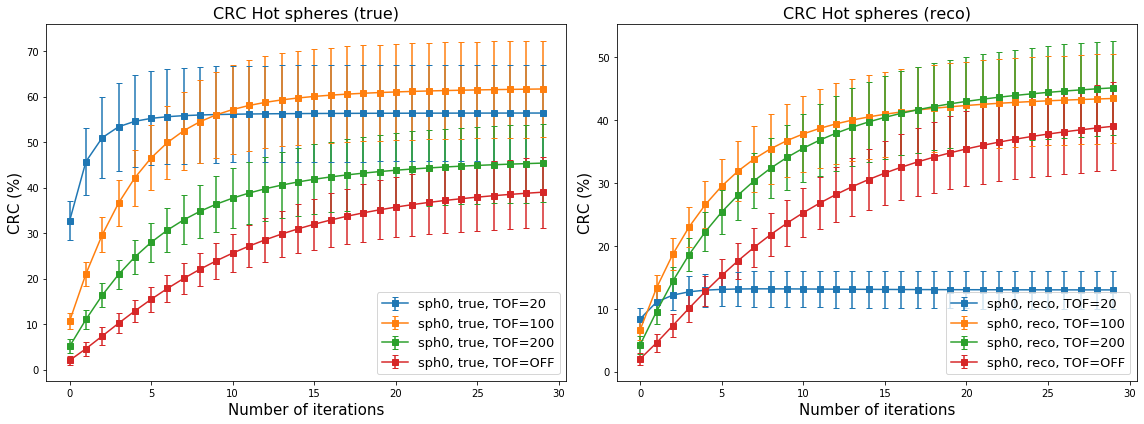

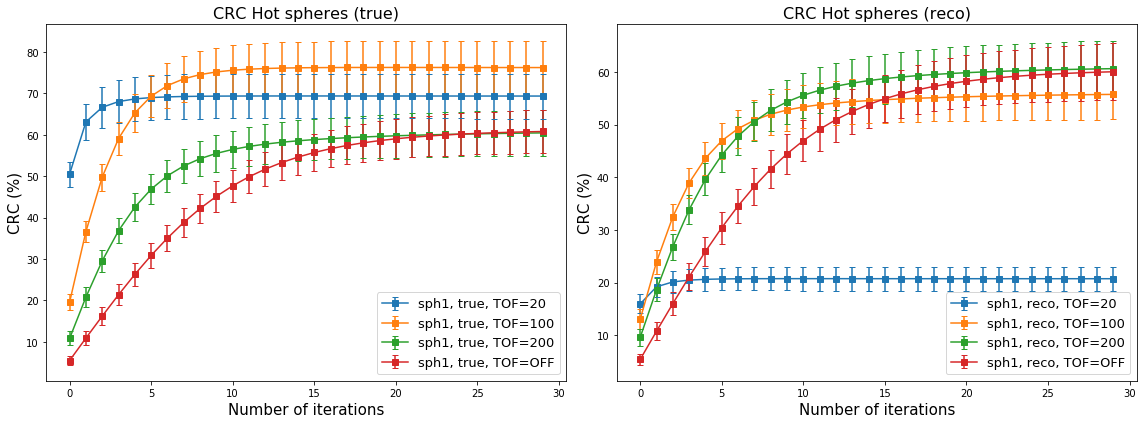

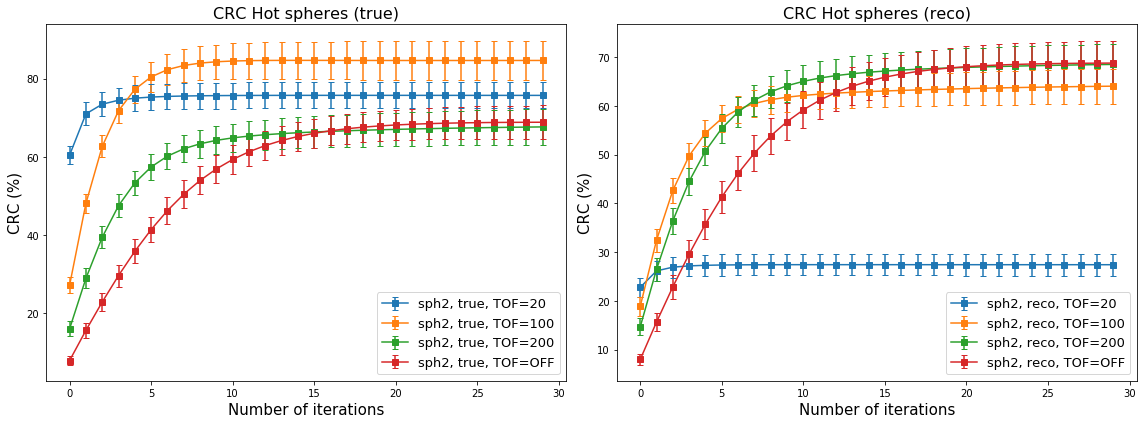

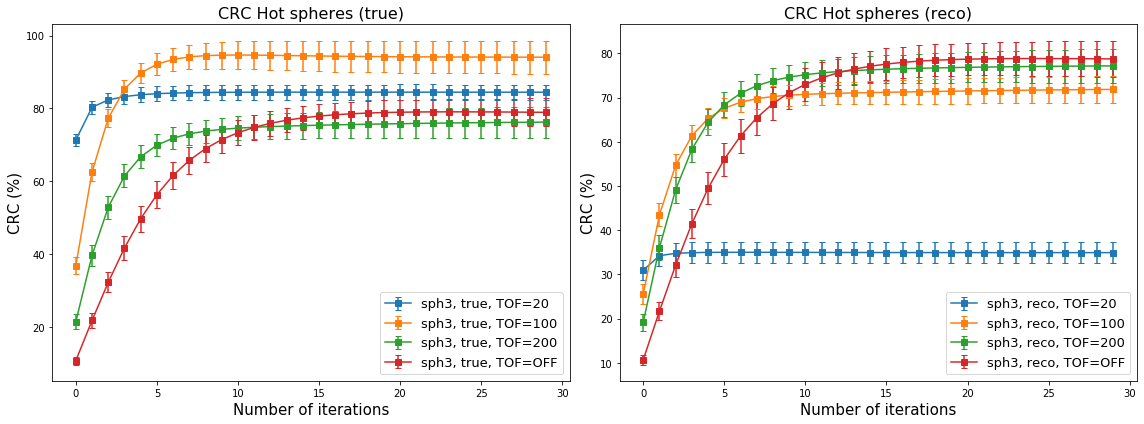

In [18]:
kd   = ['true', 'reco']
tofs = [20, 100, 200, 'OFF']
for sph in range(4):
    fig, axs = plt.subplots(1,2, figsize=(16, 6))
    for ax, true_or_reco in zip(axs.flatten(), kd):
        for tof in tofs:
            plot_crc_sphs_ax(crcs, range(sph, sph+1), true_or_reco, tof=tof, num_it=30, ax=ax)
        ax.set_title(f'CRC Hot spheres ({true_or_reco})', fontsize=16)
        ax.set_xlabel('Number of iterations', fontsize=15)
        ax.set_ylabel('CRC (%)', fontsize=15)
        ax.legend(loc=4, fontsize=13, ncol=1)
    plt.tight_layout()
    plt.show()

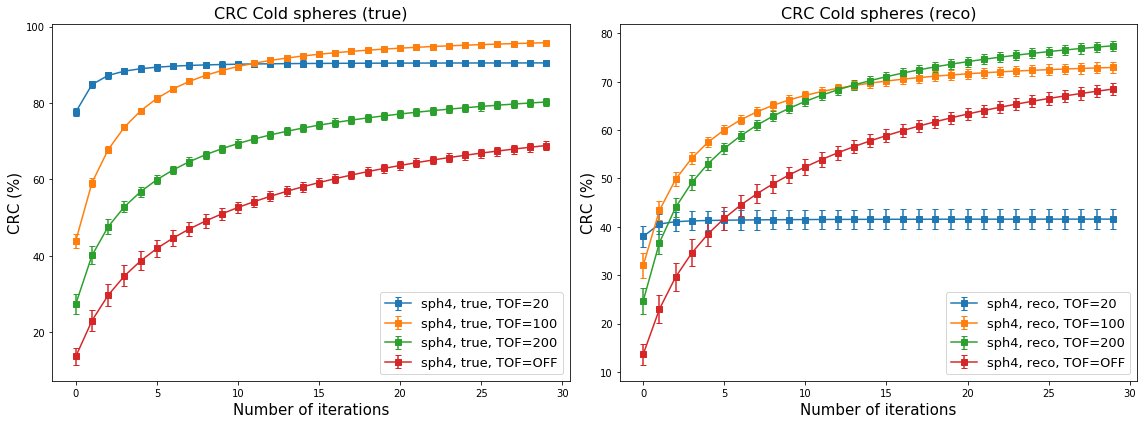

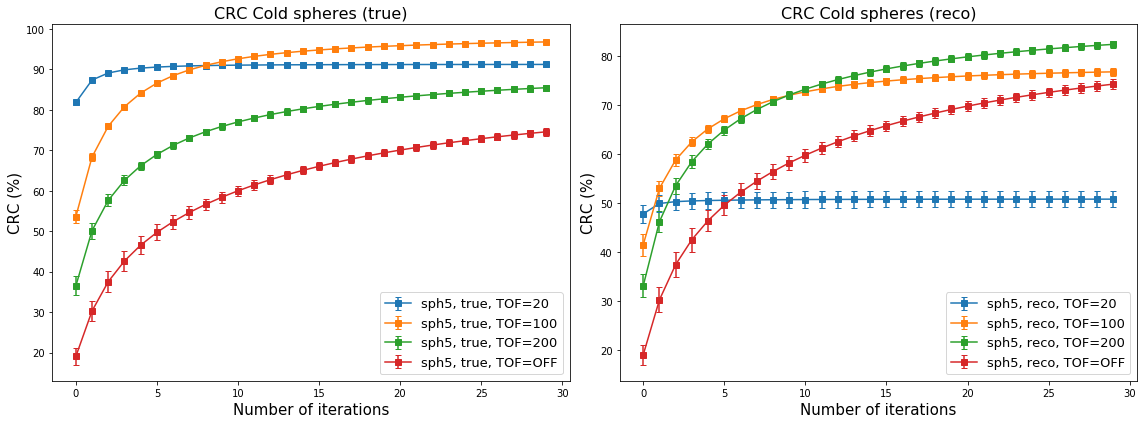

In [19]:
kd   = ['true', 'reco']
tofs = [20, 100, 200, 'OFF']
for sph in range(4, 6):
    fig, axs = plt.subplots(1,2, figsize=(16, 6))
    for ax, true_or_reco in zip(axs.flatten(), kd):
        for tof in tofs:
            plot_crc_sphs_ax(crcs_cold, range(sph, sph+1), true_or_reco, tof=tof, num_it=30, ax=ax)
        ax.set_title(f'CRC Cold spheres ({true_or_reco})', fontsize=16)
        ax.set_xlabel('Number of iterations', fontsize=15)
        ax.set_ylabel('CRC (%)', fontsize=15)
        ax.legend(loc=4, fontsize=13, ncol=1)
    plt.tight_layout()
    plt.show()